<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master//bgsedsc_0.jpg">

# Project: Unsupervised learning

## Programming project: patient clustering

In this project, you have to cluster patients that enter an ICU (Intensive Care Unit) by the features that are known on the very first day. At the end, we will check if these groups of patients have similar outcome results, in terms of length of stay or probability of death.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_unsupervised_features.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Most columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 



Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Additionally, the file *mimic_unsupervised_response.csv* contains the outcome of the patients visit to the ICU, did they die and how many days were they in the ICU for. We will use this to evaluate the clusters we produce.


Main tasks are:
+ Using *mimic_unsupervised_features.csv* file to cluster patient stays .
+ Using *mimic_unsupervised_response.csv*, check if resulting clusters are related to outcomes of patients, such as length of stay, mortality or assigned ICU.

You can follow these **steps** for your implementation:
1. *Explore* and understand the dataset. 
2. For your *first* implmentation

   i). Remove all non numeric columns (e.g ID's, dates and categories)   
   ii). Standardise the data to have 0 column means and variance 1   
   iii). Cluster the data using either K-means or spectral clustering. Show how you decided how many clusters to use

3. Then use the single valued decomposition (SVD) to reduce the dimensionality of the numerical feature space. Show how you decided how many dimensions to use. See how this affects your clustering

4. Manage the date variables e.g. try to create an Age variable, and manage categorial features e.g. create *dummy variables* for relevant categorical features.  See how this affects your clustering

5. Consider how to incorporate the comorbidity information.

6. Explore relationship between clusters and outcomes of patients

Feel free to reduce the dataset if you experience computational constraints.
As a *bonus*, explore if adding as an input feature the cluster label would improve a prediction model of mortality (e.g. try with LogisticRegression, or any non-linear model of your choice).

## Main criteria for grading – In Class
With weights for In-Class:
+ Code runs - 20%
+ Data preparation - 20%
+ Clustering algorithm used - 25%
+ Reasonable selection of number of clusters demonstrated - 25% 
+ SVD used - 5%
+ Reasonable selection of number of dimensions - 5%
+ Good exploration of relation between clusters and patient outcomes - 0%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

In [1]:
# Set working directory
%pwd
%cd /Users/philine/Documents/GitHub/CML/mimic_icu_unsupervised

/Users/philine/Documents/GitHub/CML/mimic_icu_unsupervised


In [2]:
# Load relevant packages
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.cluster import KMeans

# Import my own library
from src.mimic_icu_unsupervised_library.clustering import *

# Set SEED
SEED = 10

## Format and merge datasets
### Main dataset

In [3]:
# Load data
df = pd.read_csv('data/mimic_unsupervised_features.csv')
df.head()

,Unnamed: 0,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,2178-02-06 10:35:00,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,2129-02-12 22:34:00,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU
2,2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,2125-11-17 23:04:00,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU
3,3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,2131-01-26 08:00:00,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU
4,5,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,...,2151-08-06 19:11:00,-51044.77754,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,LARGE GASTOINTESTINAL BLEED,5550,MICU


### Comorbidity data

The comorbidity dataset contains information on the comorbidities of each patient for a particular hospital stay. As in the main dataset, comorbidity diagnoses are given by the ICD9-code which groups diagnoses together by organ system. There are two different ways to incorporate comorbidity information into our original dataset:
+ count the number of comorbidities
+ have dummies for ICD9 codes that equal one if a patient exhibits a particular comorbidity

Due to data constraints, the second method requires that either we drop the detailed classification and stick to the main organ groups, or alternatively, that we use the ICD9 dummies from our main dataset and have the dummy equal one if the patient has this diagnosis either as main diagnosis or as comorbidity.

The former is associated with a big loss of  information when it comes to the severity of the disease. Irritable bowel syndrome would for example be grouped with perforation of the intestines - the former is annoying while the latter is lethal. Furthermore, patients feature up to 38 comorbidities. It would be very computationally intensive to do this for all 38 comorbidites. Instead we would want to select the first five for example. However, we do not know whether there is a natural ordering to the listing of the comorbidities, with the most important being listed first. If this is not the case, we might drop important comorbidities, whilst keeping some that are less impactful and important. 

Using the same dummies for main diagnosis and comorbidity, meanwhile, leads to a conflation of comorbidities with the main diagnosis - we are no longer able to tell the primary reason a patient was treated in hospital

Due to the limitations an inclusion of the ICD9 codes for comorbidites poses, I decide to pursue the first option i.e. simply counting the number of comorbidites. I would assume that the on average the higher the number of comorbidites, the more severly ill is a patient.

In [4]:
# Load data
comorbidity = pd.read_csv('data/extra_data/MIMIC_diagnoses.csv')
comorbidity.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [5]:
# Collapse dataset on HADM_ID with max SEQ_NUM
# The SEQ_NUM can be interpreted as the number of comorbidities for an individual during a particular hospital stay. 
comorbidity = comorbidity.rename(columns=str.lower)
comorbidity = comorbidity.dropna()
comorbidity = comorbidity.groupby(['subject_id', 'hadm_id']).max().reset_index()

comorbidity.rename(columns={"seq_num": "comorbidity_count"}, inplace=True)
comorbidity['comorbidity_count'] = comorbidity['comorbidity_count'].astype(int)

comorbidity = comorbidity.drop(columns=['icd9_code'])

comorbidity.head()

,subject_id,hadm_id,comorbidity_count
0,2,163353,3
1,3,145834,9
2,4,185777,9
3,5,178980,3
4,6,107064,8


In [6]:
# Merge comorbidity data with the main dataset
df = pd.merge(left=df, right=comorbidity, how='left', on=['subject_id', 'hadm_id'])
df.head()

,Unnamed: 0,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,comorbidity_count
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,17
1,1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,3
2,2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,14
3,3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,15
4,5,63311,180102,287519,70.0,130.0,97.951220,107.0,155.0,128.414634,...,-51044.77754,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,LARGE GASTOINTESTINAL BLEED,5550,MICU,11


## Explore and understand the dataset

In [7]:
# Explore data
df.info()
# no missing data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17476 entries, 0 to 17475
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         17476 non-null  int64  
 1   subject_id         17476 non-null  int64  
 2   hadm_id            17476 non-null  int64  
 3   icustay_id         17476 non-null  int64  
 4   HeartRate_Min      17476 non-null  float64
 5   HeartRate_Max      17476 non-null  float64
 6   HeartRate_Mean     17476 non-null  float64
 7   SysBP_Min          17476 non-null  float64
 8   SysBP_Max          17476 non-null  float64
 9   SysBP_Mean         17476 non-null  float64
 10  DiasBP_Min         17476 non-null  float64
 11  DiasBP_Max         17476 non-null  float64
 12  DiasBP_Mean        17476 non-null  float64
 13  MeanBP_Min         17476 non-null  float64
 14  MeanBP_Max         17476 non-null  float64
 15  MeanBP_Mean        17476 non-null  float64
 16  RespRate_Min       174

In [8]:
# Drop id columns:
df = df.drop(columns=['Unnamed: 0', 'subject_id', 'hadm_id', 'icustay_id'])
#df.info()

## Analysis on numerical data only
#### 2. i). Remove all non-numeric columns

In [9]:
dfn = df.select_dtypes(exclude=['object'])
dfn = dfn.drop(columns=["Diff"])
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17476 entries, 0 to 17475
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HeartRate_Min      17476 non-null  float64
 1   HeartRate_Max      17476 non-null  float64
 2   HeartRate_Mean     17476 non-null  float64
 3   SysBP_Min          17476 non-null  float64
 4   SysBP_Max          17476 non-null  float64
 5   SysBP_Mean         17476 non-null  float64
 6   DiasBP_Min         17476 non-null  float64
 7   DiasBP_Max         17476 non-null  float64
 8   DiasBP_Mean        17476 non-null  float64
 9   MeanBP_Min         17476 non-null  float64
 10  MeanBP_Max         17476 non-null  float64
 11  MeanBP_Mean        17476 non-null  float64
 12  RespRate_Min       17476 non-null  float64
 13  RespRate_Max       17476 non-null  float64
 14  RespRate_Mean      17476 non-null  float64
 15  TempC_Min          17476 non-null  float64
 16  TempC_Max          174

<function matplotlib.pyplot.show(close=None, block=None)>

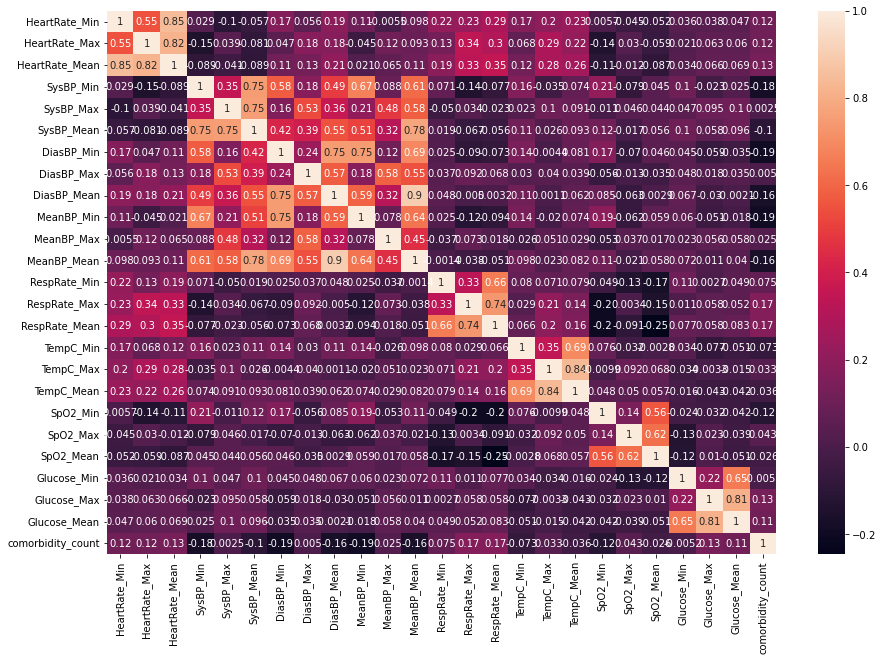

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(dfn.corr(), annot=True)
plt.show

The heatmap shows pairwise correlations of our numerical variables. We can see that some variables are strongly positively correlated. Dimensionality reduction takes advantage of this correlation between variables.

#### 2. ii). Standardise the data to have 0 column means and variance 1

In [11]:
Xn = np.array(dfn).reshape(17476, -1)

from sklearn.preprocessing import StandardScaler
Xn_scaled = StandardScaler().fit_transform(Xn)
print(Xn_scaled.shape)

(17476, 25)


### First implementation without SVD
#### 2. iii). Cluster the data using either K-means or spectral clustering. Show how you decided how many clusters to use.
I use the following methods to decide which number of clusters to use:
+ **Elbow method**: computes the within-cluster sum of squares (WCSS) for a range of number of clusters (plotted in the graph). We pick the number at the elbow, i.e. where increasing the number of clusters is not adding a sensible decrease in WCSS.
+ **Silhouette coefficient**: displays a measure of how close each point in one cluster is to points in the neighboring clusters. The measure has a range of [-1, 1]. Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster. We use the number of clusters with the maximum silhouette coefficient.
+ **Gap statistic** (as defined by  Tibshirani et al. (2001)): we select a particular number of clusters K such that the within-cluster distance improvement of selecting one more cluster is below a certain threshold.

All three methods will be used in turn and the results will be contrasted with each other.

In [ ]:
# Use elbow, silhouette score and gap stat to decide how many clusters to use
n_clusters_ne = elbow(Xn_scaled, n=15)

In [ ]:
n_clusters_ns = silhouette_score(Xn_scaled, K=range(2,15))

In [ ]:
n_clusters_ng = gap_values(Xn_scaled, n=15)

As depicted above, the silhouette score and gap method yield the same number of clusters at n_clusters = 2. The optimal number of clusters given by the elbow lies slightly above this at n_clusters = 6. I will run the KMeans for values of both 2 and 6 to see how well KMeans is able to differentiate between the different clusters for different numbers of clusters.

In [ ]:
# n_clusters = 6 (elbow)
kmeans_ne = KMeans(n_clusters=n_clusters_ne,random_state=SEED)
kmeans_ne.fit(Xn_scaled)
predicted_ne = kmeans_ne.predict(Xn_scaled)

plt.scatter(Xn_scaled[:,0],Xn_scaled[:,1],c=predicted_ne)

In [ ]:
# n_clusters = 2 (silhouette and gap)
kmeans_ns = KMeans(n_clusters=n_clusters_ns,random_state=SEED)
kmeans_ns.fit(Xn_scaled)
predicted_ns = kmeans_ns.predict(Xn_scaled)

plt.scatter(Xn_scaled[:,0],Xn_scaled[:,1],c=predicted_ns)

We can see that our KMeans algorithm on the numerical data without performing SVD is not very good at predicting clusters. In none of the three scatterplots are clusters strictly defined. Instead, we see a lot of overlap.

### Using single-value decomposition
#### 3. Then use the single valued decomposition (SVD) to reduce the dimensionality of the numerical feature space. Show how you decided how many dimensions to use. See how this affects your clustering.
I decide how many dimensions to use using the concept of explained variance. This plots the variance of the orthogonal latent factors against their index. We can determine the elbow point, at which additional latent factors no longer explain a significant proportion of the variability. An alternative would be using optimal low-rank approximation. However, this more computationally intensive, particularly once we include categorical variables.

#### Dimensionality reduction

In [ ]:
# Apply SVD
Un, Dn, Vtn, Vn = svd(Xn_scaled)
print(Un.shape, Dn.shape, Vn.shape)

In [ ]:
# Find the optimal number of dimensions using explained variance
r_evn = explained_variance(Un, Dn, r=10)

In [ ]:
# Find the optimal number of dimensions using optimal low-rank approximation
#r_lran = low_rank_approximation(25, df, Un, Dn, Vn, Xn_scaled)

In [ ]:
# Reduce dimensionality
rn = r_evn
#rn = r_lran
Zn = np.matmul(Un[:, 0:rn], np.diag(Dn[0:rn]))

#### Clustering

In [ ]:
# Find optimal number of clusters
n_clusters_nsvde = elbow(Xn_scaled, n=15)

In [ ]:
n_clusters_nsvds = silhouette_score(Xn_scaled, K=range(2,15))

In [ ]:
n_clusters_nsvdg = gap_values(Xn_scaled, n=15)

In [ ]:
# Fit K-means cluster with optimal values found above
# n_clusters = 6 (elbow)
kmeans_nsvde = KMeans(n_clusters=n_clusters_nsvde,random_state=SEED)
kmeans_nsvde.fit(Zn)
predicted_nsvde = kmeans_nsvde.predict(Zn)

plt.scatter(Zn[:,0],Zn[:,1],c=predicted_nsvde)

In [ ]:
# n_clusters = 2 (silhouette and gap)
kmeans_nsvds = KMeans(n_clusters=n_clusters_nsvds,random_state=SEED)
kmeans_nsvds.fit(Zn)
predicted_nsvds = kmeans_nsvds.predict(Zn)

plt.scatter(Zn[:,0],Zn[:,1],c=predicted_nsvds)

We can see that performing SVD drastically improves our clustering. Our methods for determining the optimal number of clusters (elbow, silhouette and gap) all yield a different number of optimal clusters, but all three numbers of clusters seem to differentiate well.

## Analysis with categorical data
#### 3. Manage the date variables e.g. try to create an Age variable, and manage categorial features e.g. create dummy variables for relevant categorical features. See how this affects your clustering

In [ ]:
# Make a copy of the dataframe for our analysis including categorical variables
dfc = df.copy()
dfc.head()

### Age
To create an age variable, I use the DOB and ADMITTIME variables. I subtract the difference given by the Diff column in order to get dates that have a real meaning. Then I calculate the time difference between these two dates in order to determine the age of an individual. Note that individuals older than 89 are encoded as 300. We thus have observations with age>300. In order to account for this, I group individuals into age groups. The following age groups are used:
+ 15-19 years 
+ 20-29 years
+ 30-39 years
+ 40-49 years
+ 50-59 years
+ 60-69 years
+ 70-79 years
+ 80-89 years
+ 90+ years

In [ ]:
# Convert the date columns to datetime format
dfc['DOB']= pd.to_datetime(dfc['DOB'], format='%Y-%m-%d')
dfc['ADMITTIME']= pd.to_datetime(dfc['ADMITTIME'], format='%Y-%m-%d')

# Add difference to make datetimes realistic
from datetime import timedelta
dfc['DOB'] = dfc['DOB'] + pd.to_timedelta(dfc.Diff, unit="d")
dfc['ADMITTIME'] = dfc['ADMITTIME'] + pd.to_timedelta(dfc.Diff, unit="d")

dfc.head()

In [ ]:
# Create an age variable: I use the naive approach where we subtract years
dfc['YOB'] = dfc['DOB'].dt.strftime('%Y').astype(int)
dfc['YADMIT'] = dfc['ADMITTIME'].dt.strftime('%Y').astype(int)

dfc['AGE'] = dfc['YADMIT'] - dfc['YOB']

print(dfc['AGE'].describe())

# Plot distribution of age
sns.histplot(data=dfc, x="AGE")
# there are observations with AGE > 300.

In [ ]:
# Make age groups
bins= [15,20,30,40,50,60,70,80,90,400]
labels = ['15-19','20-29','30-39','40-49','50-59', '60-69', '70-79', '80-89', '90+']
dfc['AGEGROUP'] = pd.cut(dfc['AGE'], bins=bins, labels=labels, right=False)

dfc.head()

In [ ]:
# delete variables related to age
dfc = dfc.drop(columns=['DOB', 'YOB', 'ADMITTIME', 'YADMIT', 'Diff', 'AGE'])

In [ ]:
sns.histplot(data=dfc, x="AGEGROUP")

### Categorical variables
The summary of categorical variables shows that there are some categorical variables that can easily be transformed into dummy variables. These include: gender, admission type, insurance, marital status and first careunit and the age group which I have created. All of these only feature a small number of categories and categories are easily differentiable. This group of categorical variables will not need to be reformatted. I reformat the remaining categorical variables.

In [ ]:
categorical_cols = dfc.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

In [ ]:
for col in categorical_cols:
    print(dfc[col].value_counts())

#### Religion
Looking at the "religion" variable we can see that it is more disaggregated than is common. Initially, I planned to group individuals into the main religious groups as speficied on wikipedia (https://en.wikipedia.org/wiki/Major_religious_groups):

+ Christianity (31.2%)
+ Islam (24.1%)
+ Irreligion (16%)
+ Hinduism (15.1%)
+ Buddhism (6.9%)
+ Folk religions (5.7%)
+ Other religions (0.5%)
+ Sikhism (0.3%)
+ Judaism (0.2%)

However, this would leave me with a highly imbalanced dataset. I have thus decided to use the largest groups in the dataset for the creation of my dummy variables and group all remaining religions in an 'Other' category. 'Unobtainable' and 'Not specified' are grouped together. The following dummies will be created:

+ Catholic
+ Protestant
+ Jewish
+ Not Specified
+ Other

In [ ]:
dfc['RELIGION'].replace({"UNOBTAINABLE": "NOT SPECIFIED", "PROTESTANT QUAKER": "PROTESTANT", "HEBREW": "JEWISH"}, inplace=True)

religion_other = ["EPISCOPALIAN",
                  "GREEK ORTHODOX",
                  "CHRISTIAN SCIENTIST",
                  "BUDDHIST",
                  "MUSLIM",
                  "UNITARIAN-UNIVERSALIST",
                  "JEHOVAH'S WITNESS",
                  "HINDU",
                  "ROMANIAN EAST. ORTH",
                  "7TH DAY ADVENTIST"]

for religion in religion_other:
    dfc['RELIGION'].replace({religion: "OTHER"}, inplace=True)

dfc['RELIGION'].value_counts()

#### Ethnicity
Ethnicity groups are even more disaggregated. Again, I merge them into the "main" ethnic groups. These include:
+ White
+ Black
+ Hispanic
+ Asian

All other ethnic groups are put into an 'Other' column unless the ethnicity is not specified.

In [ ]:
dfc.loc[dfc['ETHNICITY'].str.contains('WHITE', case=False), 'ETHNICITY'] = 'WHITE'
dfc.loc[dfc['ETHNICITY'].str.contains('HISPANIC', case=False), 'ETHNICITY'] = 'HISPANIC'
dfc.loc[dfc['ETHNICITY'].str.contains('ASIAN', case=False), 'ETHNICITY'] = 'ASIAN'
dfc.loc[dfc['ETHNICITY'].str.contains('BLACK', case=False), 'ETHNICITY'] = 'BLACK'

dfc['ETHNICITY'].replace({'PORTUGUESE': "WHITE"}, inplace=True)

unknowns = ['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER']
for unknown in unknowns:
    dfc['ETHNICITY'].replace({unknown: "UNKNOWN/NOT SPECIFIED"}, inplace=True)
    
ethnicity_other = ['MULTI RACE ETHNICITY',
                  'MIDDLE EASTERN', 
                  'AMERICAN INDIAN/ALASKA NATIVE',
                  'CARIBBEAN ISLAND',
                  'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                  'SOUTH AMERICAN',
                  'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']
for ethnicity in ethnicity_other:
    dfc['ETHNICITY'].replace({ethnicity: "OTHER"}, inplace=True)
    
dfc['ETHNICITY'].value_counts()

#### ICD9 Codes
ICD9 is a classification system used for the classification of diseases and health disorders. Each ICD9 codes consist of a 3 digit number with two decimal places. The three digit code specifies a specific disease, with the decimal places giving information as to the severity of the diagnosis. Each health disorder can be placed into one of the chapters below, which give a grouping of diseases into parent categories: 
+ 001–139	Infectious and Parasitic Diseases
+ 140–239	Neoplasms
+ 240–279	Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders
+ 280–289	Diseases of the Blood and Blood-forming Organs
+ 290–319	Mental Disorders
+ 320–389	Diseases of the Nervous System and Sense Organs
+ 390–459	Diseases of the Circulatory System
+ 460–519	Diseases of the Respiratory System
+ 520–579	Diseases of the Digestive System
+ 580–629	Diseases of the Genitourinary System
+ 630–679	Complications of Pregnancy, Childbirth, and the Puerperium
+ 680–709	Diseases of the Skin and Subcutaneous Tissue
+ 710–739	Diseases of the Musculoskeletal System and Connective Tissue
+ 740–759	Congenital Anomalies
+ 760–779	Certain Conditions originating in the Perinatal Period
+ 780–799	Symptoms, Signs and Ill-defined Conditions
+ 800–999	Injury and Poisoning
+ E800–E999	Supplementary Classification of External Causes of Injury and Poisoning
+ V01–V82	Supplementary Classification of Factors influencing Health Status and Contact with Health Services

This grouping will be used to construct dummies for the ICD9 codes.

In [ ]:
dfc['ICD9Groups'] = dfc['ICD9_diagnosis']

dfc['ICD9Groups'] = dfc['ICD9Groups'].str[:3]
dfc.loc[dfc['ICD9Groups'].str.startswith('V'), 'ICD9Groups'] = '000'

dfc['ICD9Groups'] = dfc['ICD9Groups'].astype(int)
#dfc_dummies.info()

# Make ICD9 classifications
bins= [0, 1, 140, 240, 280, 290, 320, 390, 460, 520, 580, 630, 680, 710, 740, 760, 780, 800, 1000]
labels = ['Supplementary Classification',
         'Infectious and Parasitic',
         'Neoplams',
         'Endocrine',
         'Blood',
         'Mental',
         'Nervous System',
         'Circulatory System',
         'Respiratory System',
         'Digestive System',
         'Genitourinary System',
         'Pregnancy',
         'Skin',
         'Muscoskeletal System',
         'Congenital Anomalies',
         'Perinatal',
         'Ill-defined',
         'Injury and Poisoning']

dfc['ICD9Groups'] = pd.cut(dfc['ICD9Groups'], bins=bins, labels=labels, right=False)

dfc.loc[:,['ICD9Groups', 'ICD9_diagnosis']].head(10)
dfc = dfc.drop(columns=['ICD9_diagnosis', 'DIAGNOSIS'])

In [ ]:
dfc['ICD9Groups'].value_counts()

#### Get dummies
In a last step I get dummies for all categorical variables.

In [ ]:
dfc_dummies = pd.get_dummies(dfc, columns = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'ICD9Groups', 'FIRST_CAREUNIT','AGEGROUP'], drop_first=True)
dfc_dummies.info()

#### Perform SVD to reduce dimensions

In [ ]:
Xc = np.array(dfc_dummies).reshape(17476, -1)

Xc_scaled = StandardScaler().fit_transform(Xc)
print(Xc_scaled.shape)

In [ ]:
Uc, Dc, Vtc, Vc = svd(Xc_scaled)
print(Uc.shape, Dc.shape, Vc.shape)

In [ ]:
# Optimality properties: explained variance
r_evc = explained_variance(Uc, Dc, r=75)

In [ ]:
# Reduce dimensionality
rc = r_evc
Zc = np.matmul(Uc[:, 0:rc], np.diag(Dc[0:rc]))

In [ ]:
n_clusters_csvde = elbow(Zc, n=15)

In [ ]:
n_clusters_csvds = silhouette_score(Zc, K=range(2,15))

In [ ]:
n_clusters_csvdg = gap_values(Zc, n=30)

In [ ]:
# n_clusters = 6 (elbow)
kmeans_csvde = KMeans(n_clusters=n_clusters_csvde,random_state=SEED)
kmeans_csvde.fit(Zc)
predicted_csvde = kmeans_csvde.predict(Zc)

plt.scatter(Zc[:,0],Zc[:,1],c=predicted_csvde)

In [ ]:
# n_clusters = 2 (silhouette)
kmeans_csvds = KMeans(n_clusters=n_clusters_csvds,random_state=SEED)
kmeans_csvds.fit(Zc)
predicted_csvds = kmeans_csvds.predict(Zc)

plt.scatter(Zc[:,0],Zc[:,1],c=predicted_csvds)

In [ ]:
# n_clusters = 27 (gap)
kmeans_csvdg = KMeans(n_clusters=n_clusters_csvdg,random_state=SEED)
kmeans_csvdg.fit(Zc)
predicted_csvdg = kmeans_csvdg.predict(Zc)

plt.scatter(Zc[:,0],Zc[:,1],c=predicted_csvdg)

Throughout the models used the silhouette coefficient always resulted in n_clusters = 2 and the number of clusters given by the gap values were either 2 or close to the upper bound specified (this is only a local maximum). Thus it seems that for the given dataset, elbow is the method of choice when trying to determine the number of optimal clusters. 

The new information added by the inclusion of categorical variables erased the clear boundaries between clusters. The clusters are less differentiable than when compared to those given by an analysis of numerical data only. However, this additional information could potentially increase the accuracy of clusters when predicting outcomes.

### Explore relationship between clusters and outcomes of patients
I use the predictions of the dataset with categorical variables for this analysis. The number of clusters were determined using elbow.

In [ ]:
# Load data
outcomes = pd.read_csv('data/mimic_unsupervised_response.csv')
outcomes = outcomes.drop(columns=["Unnamed: 0"])

In [ ]:
# Add a column that gives the cluster each observation is put into.
outcomes['cluster'] = predicted_csvde
outcomes.head()

In [ ]:
outcomes_means = outcomes.groupby('cluster').mean().reset_index()
outcomes_means

In [ ]:
ax = sns.violinplot(x=outcomes["cluster"], y= outcomes['LOS'])

In [ ]:
ax = sns.violinplot(x=outcomes["cluster"], y= outcomes['HOSPITAL_EXPIRE_FLAG'])

Looking at the violinplots, we can see that the distributions for length of stay are very similar between clusters. It is primarily cluster 5 that features a lower density around the mean length of stay and a higher variance for length of stay. The distributions of the other clusters look very similar.

This pattern becomes even more evident when looking at the violinplot for probability of death. Here we see that clusters 5 and 0 have some density around 1.0. This can be attributed to individuals who died during their stay in the ICU. The share of patients who died is significantly lower for patients from clusters 1, 2, 3 and 4.

Given that all clusters feature a very high density of individuals around mean values which are all very similar, it remains to be seen what predictive power these clusters have. Thus, judging by the violin plots we cannot infer if and how well our clusters are related to outcome variables.

In [ ]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=outcomes_means, x='LOS', y='HOSPITAL_EXPIRE_FLAG', hue='cluster', s=100, palette="colorblind")
plt.show()

The scatterplot plots the mean length of stay against the probability of dying. Each data point represents one cluster. We can see that clusters differ along both dimensions. There are four clusters (1, 2, 3 and 4) which group patients with a short length of stay and a low probability of death. Then there is a fifth group (0) that includes patients who remain in intensive care for a relatively short period time, but feature a higher chance of death. Lastly we have a sixth cluster (5) for which both the length of stay and the probability of dying is higher compared to the other clusters.

In terms of cluster performance, I would say that clusters 0 and 5 are good at classifying patients according to outcome variables. For clusters 1, 2, 3 and 4 outcomes are relatively similar, so these clusters are likely to be worse at correctly predicting outcomes.

In the given scatterplot, the number of clusters is too small to infer anything in terms of the predictive power of our clusters for the outcome variables. For this I would need to perform a logistic regression. However, we see that there is some relationhip between clusters and length of stay and probability of death. So it is likely that when comparing our linear classification models with and without clusters, we would see some increase in predictive power by including the clusters I have computed.